In [0]:
import numpy as np
import pandas as pd

from sklearn.metrics import log_loss

In [0]:
# Define the test scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true)

In [0]:
# load in gcollab environment
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
root_path = 'drive/My Drive/Colab Notebooks/data-science-test/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#if outside google collab 
root_path = ""

# Information about the test

In this test, the `requests` datasets contains information about the requests made by group of individuals (or family) to the french emergency housing public service. A sample of the `requests` dataset corresponds to a unique request. The `individuals` datasets contains information about each individual for all requests.
You can use the column `request_id` to link the two datasets.

The goal is to predict the categorical variable `granted_number_of_nights` which represents the number of nights of emergency housing granted to a group. You can train your model on the `requests_train`, the predictions should be made for requests listed in the `requests_test` dataset. The competition score should also be computed on the `requests_test`.

The evaluation metric is given by the `competition_scorer` defined above. It corresponds to a weighted log-loss with weights 1, 10, 100, or 1000 if the `granted_number_of_nights` takes the value 0, 1, 2, or 3 respectively. Thus beware that you will be penalized harder for classification mistakes made on the higher labels.

The score for a random prediction is shown at the end of this notebook (~1.6), your trained models should at least reach a **score below 1** to be significantly better.

Good luck!

## Data description

### File requests_train.csv

| Field name                       | Description                                                                                                                                                        | Type                     |
|----------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------|
| request\_id                      | "the id of request, which is unique in this dataset\."                                                                                                             | string                   |
| animal\_presence                 | flage indicating whether an animal is accompanying the group                                                                                                       | boolean                  |
| answer\_creation\_date           | the timestamp when the anwer was registered                                                                                                                        | timestamp \(iso format\) |
| child\_situation                 | the number representing the situation of the children in the group \(if any\)                                                                                      | integer                  |
| child\_to\_come                  | flag indicating whether the group is expecting a baby                                                                                                              | boolean                  |
| district                         | the id of the administrative district where the request is made\. Each district has its own emergency center responsible for receiving and managing the requests\. | integer                  |
| granted\_number\_of\_nights      | "the target \(train dataset only\), the categorized number of nights granted to the request"                                                                       | integer                  |
| group\_composition\_id           | the number representing the group composition                                                                                                                      | integer                  |
| group\_composition\_label        | the description of the group composition                                                                                                                           | string                   |
| group\_creation\_date            | the timestamp when the group was created in the database                                                                                                           | timestamp \(iso format\) |
| group\_id                        | "the id of the group\. A group can be linked to several requests, so not unique"                                                                                   | string                   |
| group\_main\_requester\_id       | the id of the individual making the request\. it cannot be joined with individual\_id                                                                              | string                   |
| group\_type                      | whether the group is a made of several people \(GROUP\) or just one person \(PERSON\)                                                                              | string                   |
| housing\_situation\_id           | the id of the housing situation of the group when making the request                                                                                               | integer                  |
| housing\_situation\_label        | the description of the housing situation of the group when making the request                                                                                      | string                   |
| long\_term\_housing\_request     | flag indicating whether the groupe has filed a request for a long term housing solution\.                                                                          | boolean                  |
| number\_of\_underage             | the number of individual under 18 in the group                                                                                                                     | integer                  |
| request\_backoffice\_creator\_id | the id of the emergency call center employee who received the request                                                                                              | string                   |
| request\_creation\_date          | the timestamp when the request was made\.                                                                                                                          | timestamp \(iso format\) |
| requester\_type                  | the type of person who called the emergency service \(a user / a social patrol / a third party\)                                                                   | string                   |
| social\_situation\_id            | the id representing the social situation of the group in the database                                                                                              | string                   |
| town                             | the town where the requester is living                                                                                                                             | string                   |
| victim\_of\_violence             | flag indicating whether the group includes an individual victim of violence                                                                                        | boolean                  |
| victim\_of\_violence\_type       | type of the individual victim of violence \(and if it is a case of domestic violence\)                                                                             | string                   |


In [0]:
pd.set_option('display.max_columns', None)

requests_train = pd.read_csv(filepath_or_buffer=root_path + 'data/requests_train.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)

requests_test = pd.read_csv(filepath_or_buffer=root_path + 'data/requests_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)


requests_train.head()


,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,group_id,group_main_requester_id,group_type,housing_situation_id,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type
0,130667d2964de43c511d0ead7ac66b33,f,2019-02-11 22:30:00,-1,NaN,85,1,10,man alone,2018-05-03 12:10:40.416,c62f692dcc3f31880dd3937369c6f9e1,56252a8182a732cad0d106328bf96a0b,individual,160,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-11 22:30:00,third party,9a84febc47fedaf2c81d7c755e9edc85,NaN,f,NaN
1,b1cd62fcf24eebb0f685d5eaf55317a8,f,2019-02-12 09:00:00,-1,NaN,85,1,10,man alone,2019-03-07 12:11:08.545,cbb3ae0239a3ca9a0441831bde02aaa3,b23d21c9973e5b74504a94eebe82fb75,individual,160,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-12 09:00:00,user,11f64f0547e855c5c59329b9edc63063,NaN,f,NaN
2,12cc0a18890bd4959fe42df3ae58838e,f,2019-02-01 21:00:00,-1,NaN,59,1,80,isolated child/underage,2019-03-13 12:54:15.887,a73d85877e940fd36ac23bb80ac7fbbe,5e063c21a61a5b38f8f21baebea86f50,individual,200,street,NaN,-1,686d962128c7622aa79ed91da13f5c77,2019-02-01 21:00:00,user,898ab2883f410f4c6fb042ef16329fbb,NaN,f,NaN
3,ae2d5b4dc181d29e430132f145da1556,f,2019-02-25 15:12:05.037,-1,NaN,50,2,20,woman alone,2018-10-09 14:37:29.773,5f69b8b928f84ce1e673740acb854af2,f46e831e036fe418d88d6d40ee4b0680,individual,170,NaN,NaN,-1,ec29519464c381a6630f4e480a0c000e,2019-02-25 15:12:05.037,user,3998c8e890ddc980527dd1af45dfa672,NaN,t,woman
4,d13a17ce36c832514fda2464e11c4a9f,f,2019-02-20 09:59:20.603,-1,NaN,93,2,60,group with child(ren),2018-10-02 10:47:36.931,df3a2364091c2aa9f90f2738f6b176f1,936ae1e1737f38e8f9ef3049805629f3,group,50,hotel paid by the emergency centre,NaN,-1,c8b5cc926b1d7212224a08baa9619518,2019-02-20 09:59:20.603,user,74a10d96eae43586bc3c46e89719b821,NaN,f,NaN


### File individuals_train.csv

| Field name                      | Description                                                                                                               | Type                     |
|---------------------------------|---------------------------------------------------------------------------------------------------------------------------|--------------------------|
| request\_id                     | the id of the request\. It is not unique in this dataset \(a request can be for several individual in case of a group\)\. | string                   |
| individual\_id                  | the id of the individual                                                                                                  | string                   |
| birth\_month                    | month of birth of the individual                                                                                          | integer                  |
| birth\_year                     | the year of birth of the individual                                                                                       | integer                  |
| childcare\_center\_supervision  | flag representing the fact that a child receives follow\-up care                                                          | boolean                  |
| disabled\_worker\_certification | flag representing the fact that an individual is considered disabled regarding the employement law                        | boolean                  |
| gender                          | the gender of the individual                                                                                              | boolean                  |
| housing\_situation\_2\_id       | housing situation category number of the group when making the request \(more precise\)                                   | integer                  |
| housing\_situation\_2\_label    | description of the housing situation of the group when making the request \(more precise\)                                | string                   |
| individual\_creation\_date      | timestamp of the individual creation in the database                                                                      | timestamp \(iso format\) |
| individual\_role                | description of the role of the individual                                                                                 | string                   |
| individual\_role\_2\_id         | category number of the role of the individual                                                                             | integer                  |
| individual\_role\_2\_label      | "description of the role of the individual, more precise than the former"                                                 | string                   |
| marital\_status\_id             | id of the marital status of the individual                                                                                | integer                  |
| marital\_status\_label          | description of the marital status of the individual                                                                       | string                   |
| pregnancy                       | flag representing whether the individual is pregnant \(if applicable\)                                                    | boolean                  |


In [0]:
individuals_train = pd.read_csv(filepath_or_buffer=root_path + 'data/individuals_train.csv',
                                sep=',',
                                low_memory=False,
                                error_bad_lines=False)

individuals_test = pd.read_csv(filepath_or_buffer=root_path + 'data/individuals_test.csv',
                               sep=',',
                               low_memory=False,
                               error_bad_lines=False)

individuals_train.head()

,request_id,individual_id,housing_situation_2_id,housing_situation_2_label,birth_month,birth_year,childcare_center_supervision,disabled_worker_certification,gender,individual_creation_date,individual_role,individual_role_2_id,individual_role_2_label,marital_status_id,marital_status_label,pregnancy
0,130667d2964de43c511d0ead7ac66b33,b24a8cfaaf3663bac45ca3bcd24f0b36,20,on the street,5,1977,NaN,NaN,male,2018-01-29,isolated person,30,isolated adult,10,single person,f
1,b1cd62fcf24eebb0f685d5eaf55317a8,eef783d1bda82661a751c12c34aff8c2,20,on the street,5,1980,NaN,NaN,male,2019-03-07,NaN,30,isolated adult,-1,NaN,f
2,12cc0a18890bd4959fe42df3ae58838e,927b6fa58d6be263c411332835b11fec,20,on the street,1,2003,NaN,NaN,male,2019-03-13,NaN,10,isolated underage/child,-1,NaN,f
3,ae2d5b4dc181d29e430132f145da1556,94181d5cf4a56cc84d12677df84e2e03,20,on the street,7,1986,NaN,NaN,female,2018-10-09,NaN,30,isolated adult,-1,NaN,f
4,d13a17ce36c832514fda2464e11c4a9f,e79d2e3f9ace50049f1796c098008c13,35,hotel paid by the emergency structure,9,1980,NaN,NaN,female,2017-06-22,husband/spouse,1,partner,-1,NaN,f


# EDA 

In [0]:
requests_train.describe()

,child_situation,district,granted_number_of_nights,group_composition_id,housing_situation_id,number_of_underage
count,238191.000000,238191.000000,238191.000000,238191.000000,238191.000000,238191.000000
mean,-0.322304,7078.893573,0.689199,27.939679,121.939872,-0.575530
std,4.086288,46551.615070,0.769985,28.893907,83.223893,0.860536
min,-1.000000,1.000000,0.000000,10.000000,10.000000,-1.000000
25%,-1.000000,35.000000,0.000000,10.000000,10.000000,-1.000000
50%,-1.000000,61.000000,1.000000,10.000000,170.000000,-1.000000
75%,-1.000000,81.000000,1.000000,40.000000,200.000000,0.000000
max,70.000000,315842.000000,3.000000,120.000000,220.000000,14.000000


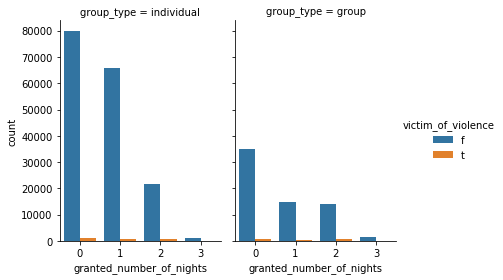

In [0]:
import seaborn as sns
g = sns.catplot(x="granted_number_of_nights", hue="victim_of_violence", col="group_type",
                data=requests_train, kind="count",
                height=4, aspect=.7);

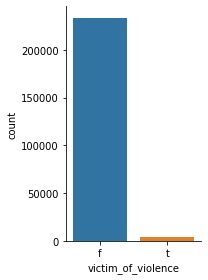

In [0]:
import seaborn as sns
g = sns.catplot(x="victim_of_violence", 
                data=requests_train, kind="count",
                height=4, aspect=.7);

<Figure size 1440x2160 with 0 Axes>

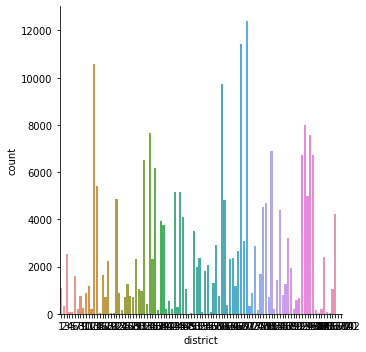

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,30))

g = sns.catplot(x="district", 
                data=requests_train, kind="count")


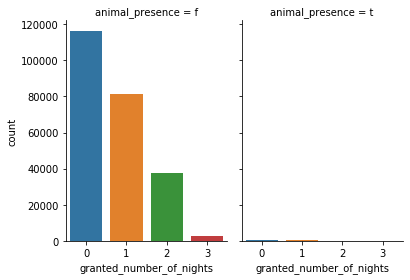

In [0]:
import seaborn as sns
g = sns.catplot(x="granted_number_of_nights", col="animal_presence",
                data=requests_train, kind="count",
                height=4, aspect=.7);


In [0]:
print("animal present:",len(requests_train[requests_train.animal_presence == "t"])/len(requests_train))
print("animal not present:",len(requests_train[requests_train.animal_presence == "f"])/len(requests_train))
# so few observations with animals present that I will drop the variable

animal present: 0.002783480484149275
animal not present: 0.9972165195158508


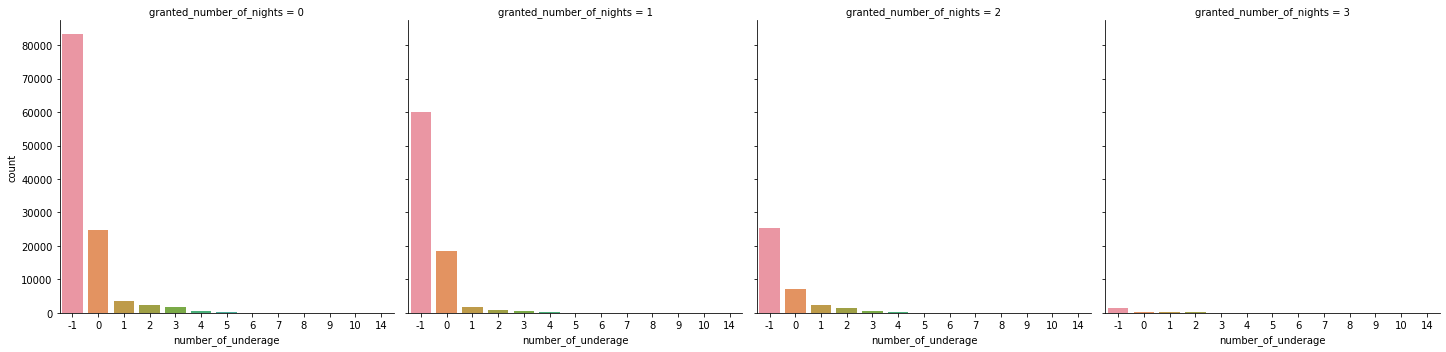

In [0]:
import seaborn as sns
g = sns.catplot(col="granted_number_of_nights", x="number_of_underage",
                data=requests_train, kind="count")

# Merge both datasets for visualisation





In [0]:
merged_train_all = requests_train.merge(individuals_train, how='left', on="request_id")
merged_test_all = requests_test.merge(individuals_test, how='left', on="request_id")

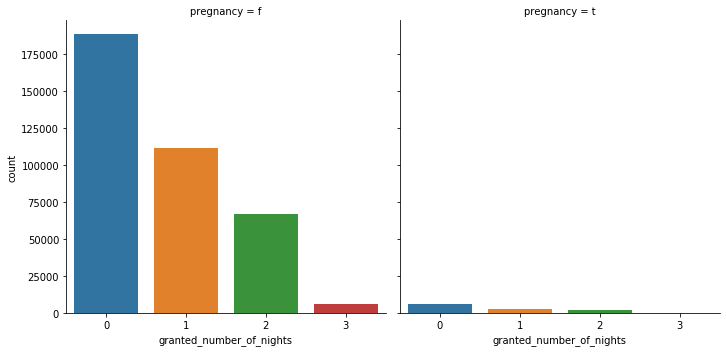

In [0]:
import seaborn as sns
g = sns.catplot(x="granted_number_of_nights", col="pregnancy",
                data=merged_train_all, kind="count")

In [0]:
print("pregnant present:",len(merged_train_all[merged_train_all.pregnancy == "t"])/len(merged_train_all))
print("not pregnant:",len(merged_train_all[merged_train_all.pregnancy == "f"])/len(merged_train_all))

pregnant present: 0.02912793225263125
not pregnant: 0.970835622037159


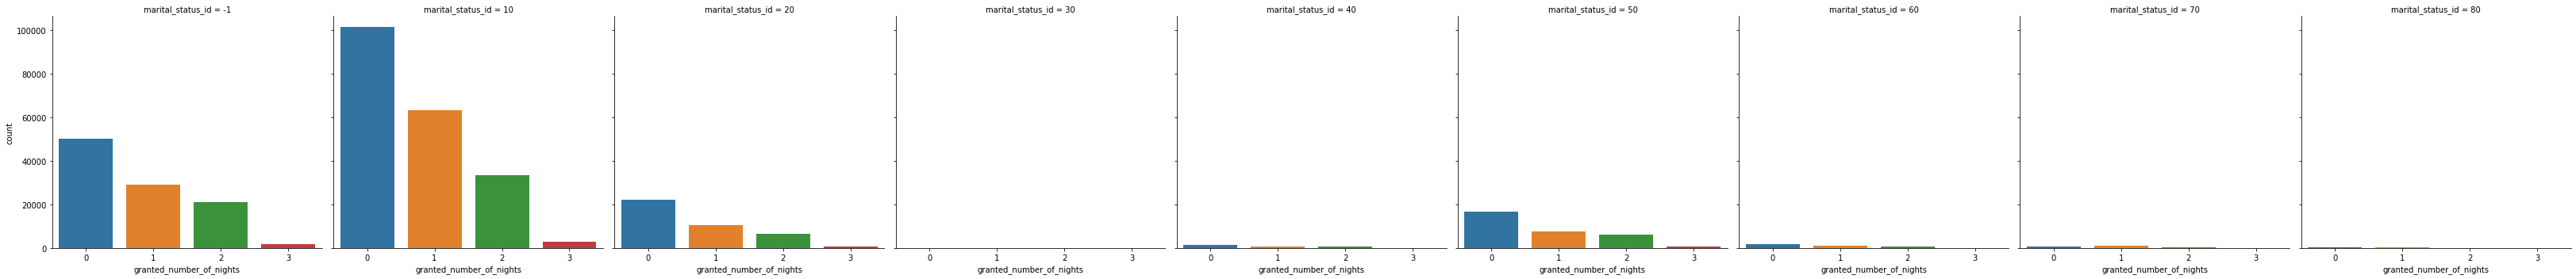

In [0]:
import seaborn as sns
g = sns.catplot(x="granted_number_of_nights", col="marital_status_id",
                data=merged_train_all, kind="count")

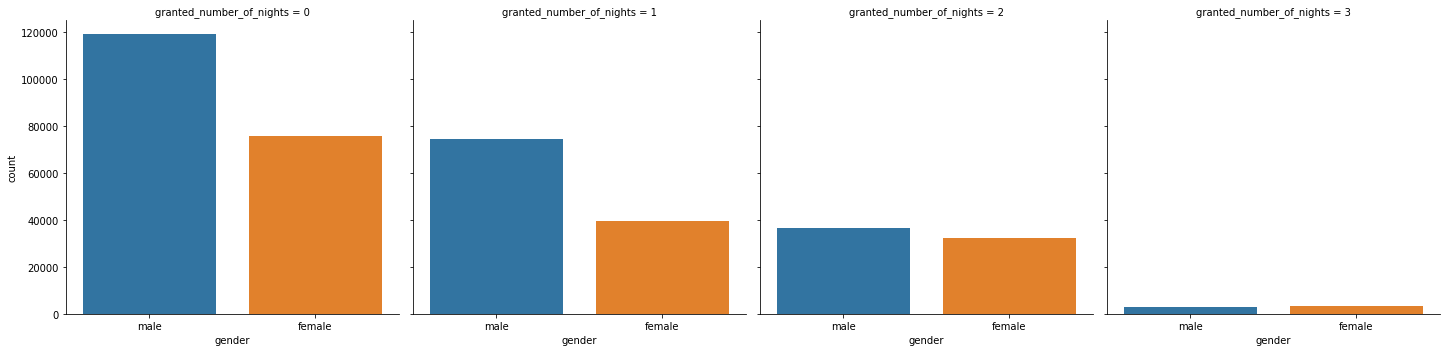

In [0]:
import seaborn as sns
g = sns.catplot(col="granted_number_of_nights", x="gender",
              data=merged_train_all, kind="count",estimator=lambda x: len(merged_train_all) / len(merged_train_all) * 100)



# Partial Merge for Prediction

In [0]:
# merging individuals and requests
#only use birth year and gender from individuals dataset
individuals_subset_train = individuals_train[["request_id","birth_year","gender"]]
individuals_subset_test = individuals_test[["request_id","birth_year","gender"]]

merged_train = requests_train.merge(individuals_subset_train, how='left', on="request_id")
merged_test = requests_test.merge(individuals_subset_test, how='left', on="request_id")
merged_train.head()

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,group_id,group_main_requester_id,group_type,housing_situation_id,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type,birth_year,gender
0,130667d2964de43c511d0ead7ac66b33,f,2019-02-11 22:30:00,-1,NaN,85,1,10,man alone,2018-05-03 12:10:40.416,c62f692dcc3f31880dd3937369c6f9e1,56252a8182a732cad0d106328bf96a0b,individual,160,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-11 22:30:00,third party,9a84febc47fedaf2c81d7c755e9edc85,NaN,f,NaN,1977,male
1,b1cd62fcf24eebb0f685d5eaf55317a8,f,2019-02-12 09:00:00,-1,NaN,85,1,10,man alone,2019-03-07 12:11:08.545,cbb3ae0239a3ca9a0441831bde02aaa3,b23d21c9973e5b74504a94eebe82fb75,individual,160,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-12 09:00:00,user,11f64f0547e855c5c59329b9edc63063,NaN,f,NaN,1980,male
2,12cc0a18890bd4959fe42df3ae58838e,f,2019-02-01 21:00:00,-1,NaN,59,1,80,isolated child/underage,2019-03-13 12:54:15.887,a73d85877e940fd36ac23bb80ac7fbbe,5e063c21a61a5b38f8f21baebea86f50,individual,200,street,NaN,-1,686d962128c7622aa79ed91da13f5c77,2019-02-01 21:00:00,user,898ab2883f410f4c6fb042ef16329fbb,NaN,f,NaN,2003,male
3,ae2d5b4dc181d29e430132f145da1556,f,2019-02-25 15:12:05.037,-1,NaN,50,2,20,woman alone,2018-10-09 14:37:29.773,5f69b8b928f84ce1e673740acb854af2,f46e831e036fe418d88d6d40ee4b0680,individual,170,NaN,NaN,-1,ec29519464c381a6630f4e480a0c000e,2019-02-25 15:12:05.037,user,3998c8e890ddc980527dd1af45dfa672,NaN,t,woman,1986,female
4,d13a17ce36c832514fda2464e11c4a9f,f,2019-02-20 09:59:20.603,-1,NaN,93,2,60,group with child(ren),2018-10-02 10:47:36.931,df3a2364091c2aa9f90f2738f6b176f1,936ae1e1737f38e8f9ef3049805629f3,group,50,hotel paid by the emergency centre,NaN,-1,c8b5cc926b1d7212224a08baa9619518,2019-02-20 09:59:20.603,user,74a10d96eae43586bc3c46e89719b821,NaN,f,NaN,1980,female


# Cleaning Data

In [0]:
# replace "f" by False and "t" by True
merged_train = merged_train.replace('f', False)
merged_test = merged_test.replace('t', True)

drop_columns = [
                #see above
                "animal_presence",
                #creation dates / system logs 
                "answer_creation_date",
                "request_id",
                "group_creation_date",
                "request_creation_date",
                "request_backoffice_creator_id",
                #ids
                "group_id",
                "group_composition_id",
                "group_composition_label",
                "group_main_requester_id",
                "social_situation_id",               
                ]
# i take out creation dates, I might look at them later in detail - for example mapping them to "has been registered before" - yes no 

merged_train = merged_train.drop(drop_columns, axis=1)
merged_test = merged_test.drop(drop_columns, axis=1)

In [0]:
# missing values
merged_train.isnull().sum()

child_situation                   0
child_to_come                232192
district                          0
granted_number_of_nights          0
group_type                        0
housing_situation_id              0
housing_situation_label       23309
long_term_housing_request    263872
number_of_underage                0
requester_type                    0
town                         253287
victim_of_violence                0
victim_of_violence_type      377088
birth_year                        0
gender                            1
dtype: int64

## Comments on missing values
* child to come - assumption that data is not missing at random and no entry means false. same for long_term_housing_request,


* housing_situation_id & housing_situation_label - the missing values in housing label can be recreated through a mapping to housing situation id. Dropping housing_situation_label for now, information can be recreated if needed. 

* dropping victim_of_violence_type because we only have data points for 2% of all observations here



* town -> we impute by the mean for now 


In [0]:
for col in ["child_to_come","long_term_housing_request"]:
  merged_train[col].fillna(False, inplace=True)
  merged_test[col].fillna(False, inplace=True)

merged_train = merged_train.drop(["victim_of_violence_type","housing_situation_label"],axis=1)
merged_test = merged_test.drop(["victim_of_violence_type","housing_situation_label"],axis=1)

In [0]:
#impute gender town and group tyoe with mean for now
for col in ['town', 'gender',"group_type"]:
    merged_train[col].fillna(merged_train[col].mode()[0], inplace=True)
    merged_test[col].fillna(merged_test[col].mode()[0], inplace=True)

#remove the accent 
!pip install unidecode
import unidecode
merged_test["town"] = [unidecode.unidecode(row) for row in merged_test["town"]]
merged_test["town"] = [unidecode.unidecode(row) for row in merged_test["town"]]


     |████████████████████████████████| 245kB 2.8MB/s 


In [0]:
merged_test.isnull().sum()
merged_train.isnull().sum()

child_situation              0
child_to_come                0
district                     0
granted_number_of_nights     0
group_type                   0
housing_situation_id         0
long_term_housing_request    0
number_of_underage           0
requester_type               0
town                         0
victim_of_violence           0
birth_year                   0
gender                       0
dtype: int64

In [0]:
merged_test.dtypes

child_situation               int64
child_to_come                object
district                      int64
granted_number_of_nights      int64
group_type                   object
housing_situation_id          int64
long_term_housing_request    object
number_of_underage            int64
requester_type               object
town                         object
victim_of_violence           object
birth_year                    int64
gender                       object
dtype: object

In [0]:
#recoding columsn to the right type

#recoding variables as boolean that are boolean
for cols in ["child_situation","child_to_come", "victim_of_violence","long_term_housing_request"]:
  merged_train[cols] = merged_train[cols].astype('bool')
  merged_test[cols] = merged_test[cols].astype('bool')

for cols in ["granted_number_of_nights","group_type","requester_type", "gender","town","district","housing_situation_id"]:
  merged_train[cols] = merged_train[cols].astype('category')
  merged_test[cols] = merged_test[cols].astype('category')


In [0]:
merged_train.dtypes

child_situation                  bool
child_to_come                    bool
district                     category
granted_number_of_nights     category
group_type                   category
housing_situation_id         category
long_term_housing_request        bool
number_of_underage              int64
requester_type               category
town                         category
victim_of_violence               bool
birth_year                      int64
gender                       category
dtype: object

## Penalized Logistic Regression

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

X_train = merged_train.drop(['granted_number_of_nights'], axis=1)
y_train = merged_train['granted_number_of_nights'].astype('category')

X_test = merged_test.drop(['granted_number_of_nights'], axis=1)
y_test = merged_test['granted_number_of_nights'].astype('category')

numeric = X_train.select_dtypes(include=['int']).columns
categorical = X_train.select_dtypes(include=['category']).columns
boolean = X_train.select_dtypes(include=['bool']).columns

In [0]:

#####Encode categorical variables
for feature in categorical:
  #if (feature != "town") & (feature != "district" ):
    print(feature)
    le = preprocessing.LabelEncoder()
    # fit label encoder on complete data set to see all labels in test set 
    le.fit_transform(X_train[feature].append(X_test[feature]))
    print(le.classes_)
    X_train[feature] = le.transform(X_train[feature])
    X_test[feature] = le.transform(X_test[feature])


district
[     1      2      3      4      5      6      7      8      9     10
     11     12     13     14     15     16     17     18     19     21
     22     23     24     25     26     27     28     29     30     31
     32     33     34     35     36     37     38     39     40     41
     42     43     44     45     46     47     48     49     50     51
     52     53     54     55     56     57     58     59     60     61
     62     63     64     66     67     68     69     70     71     72
     73     74     75     78     79     80     81     82     83     84
     85     86     87     88     89     90     91     92     93     94
     95     96     97     98     99    100    101 314550 315670 315710
 315770 315842]
group_type
['group' 'individual']
housing_situation_id
[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220]
requester_type
['social patrol' 'third party' 'user']
town
['Abbeville' 'Ablon-sur-Seine' 'Acheres' ... 'Évry' 'Ézanvil

In [0]:
#Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
X_train.head()

In [0]:
from sklearn.linear_model import LogisticRegression
class_weight = {
    0:1,
    1:10,
    2:100,
    3:1000
}
lr = LogisticRegression(random_state=42,multi_class="multinomial",class_weight = class_weight)
lr.fit(X_train, y_train)
#probability threshold is by default 0.5
y_pred = lr.predict(X_test)

y_pred_probas = lr.predict_proba(X_test)
competition_scorer(np.array(y_test), y_pred_probas)


0.9550964473887367

In [0]:
# fine tune logistic regression classifier 
from sklearn.model_selection import GridSearchCV
param_grid_lr = {
  'C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
  'penalty' : ['l2','l1']
}

lr = LogisticRegression(random_state=42,multi_class="multinomial",class_weight = class_weight)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = lr, param_grid = param_grid_lr,  n_jobs = -1, verbose = 2,cv=3)

# fit and get best parameters
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.3min finished


{'C': 0.1, 'penalty': 'l2'}

In [0]:
#applying new params 
lr = LogisticRegression(penalty='l2', C= 0.1,random_state=42,multi_class="multinomial",class_weight = class_weight)
lr.fit(X_train, y_train)
#probability threshold is by default 0.5
y_pred = lr.predict(X_test)

y_pred_probas = lr.predict_proba(X_test)
competition_scorer(np.array(y_test), y_pred_probas)


0.9550962903540493

# Evaluation

In [0]:
random_preds = np.random.uniform(size=(requests_test.shape[0], 4))
y_true = requests_test.granted_number_of_nights.values
random_score = competition_scorer(y_true, random_preds)

print(f'test score: {random_score}')

In [0]:
# Define the test scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true)